In [1]:
import nltk
print('hello world')

hello world


In [2]:
def foo():
    print('foo')
foo()

foo


In [3]:
#TESTING DATA EXTRACTION
import pandas
#pandas.read_excel(r'C:\Users\n1555085\Downloads\Copy of CSAT Help hub April Responses.xlsx')
sheet = pandas.read_excel(r'C:\Users\n1555085\Downloads\May Help Hub Data.xlsx')
courtesy = sheet['Unnamed: 9'].dropna().values.tolist()[1:]
effectiveness = sheet['Unnamed: 10'].dropna().values.tolist()[1:]
timeliness = sheet['Unnamed: 11'].dropna().values.tolist()[1:]
understanding = sheet['Unnamed: 12'].dropna().values.tolist()[1:]
nps = sheet['Unnamed: 13'].dropna().values.tolist()[1:]
comments = courtesy + effectiveness + timeliness + understanding + nps
date = sheet['Unnamed: 1'].dropna().values.tolist()[1:]
#should add completion rate

print(f'# of courtesy comments: {len(courtesy)}')
print(f'# of effectiveness comments: {len(effectiveness)}')
print(f'# of timeliness comments: {len(timeliness)}')
print(f'# of understanding comments: {len(understanding)}')
print(f'# of nps comments: {len(nps)}')
print(f'# of comments: {len(comments)}')

# of courtesy comments: 10
# of effectiveness comments: 17
# of timeliness comments: 24
# of understanding comments: 13
# of nps comments: 148
# of comments: 212


In [4]:
print('hi')

hi


In [5]:
#TRAINING DATA PREPARATION

#read from corpus, remove stopwords
from nltk.corpus import stopwords
from string import punctuation

with open(r'C:\Users\n1555085\Downloads\Project\positiveComments.txt', 'r') as f:
    posReviews = f.readlines()
with open(r'C:\Users\n1555085\Downloads\Project\negativeComments.txt', 'r') as f:
    negReviews = f.readlines()
print(len(posReviews), len(negReviews))

sw = set(stopwords.words('english') + list(punctuation))
notStopwords = ['not', 'no', '!', 'but', 'too', 'have', 'had']

def removeStopwords(review):
    #review.translate(None, string.punctuation)
    return ' '.join([word for word in review.split() if word.lower() not in sw or word.lower() in notStopwords])
posReviews = list(filter(lambda s: s , list(map(removeStopwords, posReviews))))
negReviews = list(filter(lambda s: s , list(map(removeStopwords, negReviews))))

posReviews[0:5]
#negReviews[0:5]

4553 1574


['Spenser Cameron set assisted issues. exceptional trying assist newcomer new systems.',
 'second consultant awesome appropriate follow well letting know break fix consultants suggestion since could not receive emails. best.',
 'support personnel helpful patient issue',
 'fast service.',
 'Greeting robotic, however loosened conversation went on.']

In [6]:
#define pos and neg bag-of words, and vocabulary

posWords = [word.lower() for review in posReviews for word in review.split()]
negWords = [word.lower() for review in negReviews for word in review.split()]
vocabulary = list(set(posWords + negWords))
#vocabulary[0:100]

In [7]:
#define training data: list of (review list of words, label) tuples
trainingData = [(r.split(), 'pos') for r in posReviews] + [(r.split(), 'neg') for r in negReviews]

In [8]:
#NAIVE BAYES CLASSIFIER: extract feature vector from each review, train classifier
def featureVector(reviewSplit):
    reviewWords = set(reviewSplit)
    features = {}
    for word in vocabulary:
        features[word] = word in reviewWords
    return features

naiveBayesClassifier = nltk.NaiveBayesClassifier.train(nltk.classify.apply_features(featureVector, trainingData))

#classify functions
def NBclassify(review):
    review = removeStopwords(review)
    features = featureVector(review.split())
    probDist = naiveBayesClassifier.prob_classify(features)
    confidence = max(probDist.prob('pos'), probDist.prob('neg'))
    #pos and neg add to 1
    return (naiveBayesClassifier.classify(features).upper(), confidence)

def NBclassifyComments(comments):
    return [(c, NBclassify(c)) for c in comments]

In [34]:
NBlabeledComments = NBclassifyComments(effectiveness)

In [11]:
#SVM CLASSIFIER TRAINING
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC

#vectorizer = TfidfVectorizer(min_df = 5, max_df = 0.8, sublinear_tf = True, use_idf = True, ngram_range=(1, 2))
vectorizer = CountVectorizer(ngram_range=(1, 2), token_pattern=r'\b\w+\b', min_df=1)
train_vectors = vectorizer.fit_transform(posReviews + negReviews)
labelsList = ['pos'] * len(posReviews) + ['neg'] * len(negReviews)

classifier_linear = SVC(kernel='linear', probability = True)
classifier_linear.fit(train_vectors, labelsList)

classifier_poly = SVC(kernel='poly', probability = True)
classifier_poly.fit(train_vectors, labelsList)

classifier_rbf = SVC(kernel='rbf', probability = True)
classifier_rbf.fit(train_vectors, labelsList)

classifier_sigmoid = SVC(kernel='sigmoid', probability = True)
classifier_sigmoid.fit(train_vectors, labelsList)

# svm kernel can be ‘linear’, ‘poly’, ‘rbf’, or ‘sigmoid’
def SVMclassify(review, kernel):
    review = removeStopwords(review)
    review_vector = vectorizer.transform([review]) # vectorizing
    if kernel == 'linear':
        return (classifier_linear.predict(review_vector)[0], max(classifier_rbf.predict_proba(review_vector)[0]))
    elif kernel == 'poly':
        return (classifier_poly.predict(review_vector)[0], max(classifier_rbf.predict_proba(review_vector)[0]))
    elif kernel == 'rbf':
        return (classifier_rbf.predict(review_vector)[0], max(classifier_rbf.predict_proba(review_vector)[0]))
    elif kernel == 'sigmoid':
        return (classifier_sigmoid.predict(review_vector)[0], max(classifier_rbf.predict_proba(review_vector)[0]))
    return None

def SVMclassifyComments(comments, kernel):
    return [(c, SVMclassify(c, kernel)) for c in comments]

In [30]:
#Labelling new data
SVMlabelledComments = SVMclassifyComments(comments, 'rbf')
labelledPos = []
labelledNeg = []
#lc is (<comment>, (<pos/neg>, <confidence>))
for lc in SVMlabelledComments:
    if lc[1][0] == 'pos':
        labelledPos.append(lc[0])
    elif lc[1][0] == 'neg':
        labelledNeg.append(lc[0])
#remove stopwords
labelledPos = list(filter(lambda s: s , list(map(removeStopwords, labelledPos))))
labelledNeg = list(filter(lambda s: s , list(map(removeStopwords, labelledNeg))))

#param [(<comment>, (<label>, <confidence>))]
def printLabels(labelledComments):
    print('OUTPUT OF SUPPORT VECTOR MACHINE CLASSIFIER:')
    print(f'{len(labelledPos)} positive-labeled comments, {len(labelledNeg)} negative-labeled comments\n\n')
    for lc in labelledComments:
        print(lc[1][0].upper(), round(lc[1][1], 3), ':', f'\"{lc[0]}\"', '\n')

printLabels(SVMlabelledComments)

OUTPUT OF SUPPORT VECTOR MACHINE CLASSIFIER:
167 positive-labeled comments, 42 negative-labeled comments


NEG 0.98 : "They reached out with instructions. I tried the instructions and it still did not work for me. They reached out to meet. I was busy. Then they closed the ticket with no resolution so now I have to start the request all over again." 

NEG 0.853 : "I submitted numerous requests through the chat portal and received absolutely no response." 

POS 0.939 : "." 

POS 0.954 : "efficient" 

NEG 0.93 : "No one contacted me by phone. I received a message to try an resolve the issue internally and the ticket was placed in resolved status. The issue has NOT been resolved." 

NEG 0.651 : "It was all done via email so no face to face. Very responsive." 

POS 0.811 : "Resolution was via email so it was a canned response." 

POS 0.939 : "x" 

POS 0.985 : "fast and nice support given" 

POS 0.688 : "People I interacted with were professional and courteous. No issues there." 

NEG 0.818 

In [13]:
#NMF CLUSTERING MODEL
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

def get_topics(components, feature_names, n=50):
    for idx, topic in enumerate(components):
        print("\nTopic %d: " % (idx+1), [(feature_names[i], topic[i].round(2)) for i in topic.argsort()[:-n - 1:-1]])
        
v = TfidfVectorizer(max_features=1000) 
X = v.fit_transform(labelledPos)

nmf_model = NMF(n_components=2, init='random', random_state=0)
nmf_top = nmf_model.fit_transform(X)

terms = v.get_feature_names() 
#get_topics(nmf_model.components_,terms)
#nmf_model.components_

for idx, topic in enumerate(nmf_model.components_):
    if idx == 0:
        topic_x = [(terms[i], topic[i].round(2)) for i in topic.argsort()[:-1000 - 1:-1]]
        topic_x = {i[0]:i[1] for i in topic_x}
#wordcloud = WordCloud(width = 3000, height = 3000, stopwords=STOPWORDS, background_color="white", min_font_size = 30)
#wordcloud = wordcloud.generate_from_frequencies(topic_x)

In [19]:
#WORDCLOUD STUFF
from wordcloud import WordCloud
import matplotlib.pyplot as plt

cloudStopwords = set(stopwords.words('english') + list(punctuation))
ignore = ['resolve', 'resolved', 'resolution', 'issue', 'problem', 'solve', 'ticket', 'request']
cloudStopwords = cloudStopwords.union(set(ignore))

#calculates word frequencies for generating wordcloud
#parameter should be list of comments, returns dictionary
def wordFrequencies(commentList):
    dictionary = {}
    words = ' '.join(commentList).lower().split()
    for w in words:
        if w not in dictionary and w not in cloudStopwords:
            dictionary[w] = words.count(w)
    return dictionary

def customWordFrequencies(commentList, customWords):
    dictionary = {}
    words = ' '.join(commentList).lower().split()
    for w in words:
        if w in customWords and w not in cloudStopwords:
            dictionary[w] = words.count(w)
    return dictionary

In [36]:
#POS/NEG WORDCLOUDS
posCloud = WordCloud(width = 2000, height = 2000, background_color="white", min_font_size = 30, max_words = 30)
posCloud.generate_from_frequencies(wordFrequencies(labelledPos))

negCloud = WordCloud(width = 2000, height = 2000, background_color="white", min_font_size = 30, max_words = 30)
negCloud.generate_from_frequencies(wordFrequencies(labelledNeg))
#negCloud.generate(' '.join(labelledNeg).lower())
#collocation_threshold??

#posCloud.to_file("positive_comments_wc.png")
#negCloud.to_file("negative_comments_wc.png")

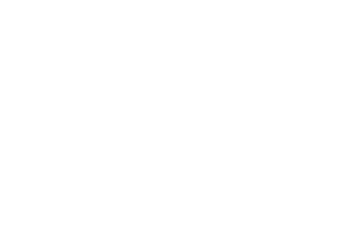

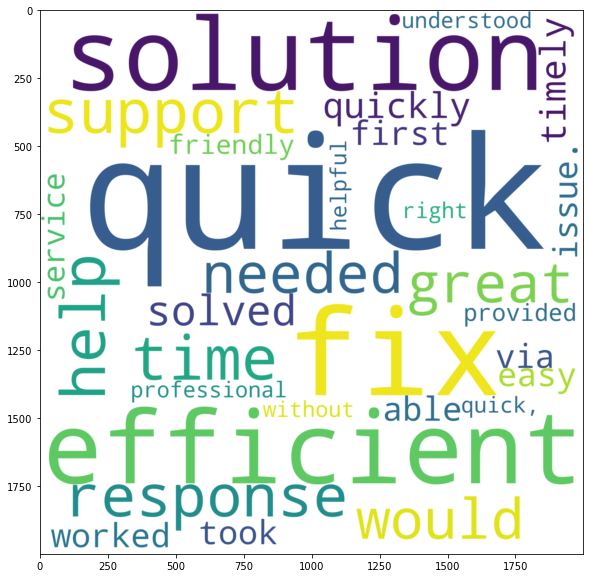

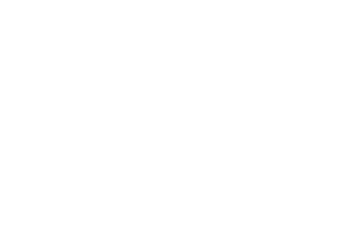

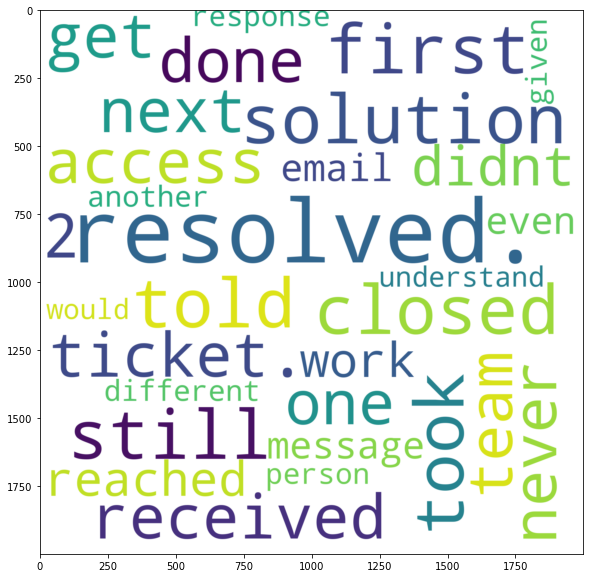

In [21]:
plt.axis("off")
plt.figure(figsize=(10, 10))
plt.imshow(posCloud, interpolation="bilinear")
plt.show()
plt.axis("off")
plt.figure(figsize=(10, 10))
plt.imshow(negCloud, interpolation="bilinear")
plt.show()

In [17]:
#KMEANS CLUSTERING MODEL
from sklearn.cluster import KMeans
import numpy as np
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.probability import FreqDist
from collections import defaultdict
from heapq import nlargest

#uses KMeans algorithm to cluster comments into numClusters groups
#takes in comment list and number of clusters as param
#returns dictionary of clusters (cluster number key : list of comments value) (<int> : <list(str)>)
def clusterComments(comments, numClusters):
    tfidf = TfidfVectorizer(min_df = 5, max_df = 0.8, sublinear_tf = True, use_idf = True, ngram_range=(1, 2))
    x = tfidf.fit_transform(comments)
    km = KMeans(n_clusters = numClusters, init = 'k-means++', max_iter = 100, n_init = 1, verbose = True)
    km.fit(x)
    np.unique(km.labels_, return_counts = True)
    print(len(km.labels_))
    dictionary = {}
    for i,cluster in enumerate(km.labels_):
        c = comments[i]
        if cluster not in dictionary.keys():
            dictionary[cluster] = [c.lower()]
        else:
            dictionary[cluster].append(c.lower())
    #print(dictionary)
    return dictionary

#takes in result of clusterComments
#returns dictionary of <cluster : keywords>
def findKeywords(dictionary):
    keywords = {}
    for cluster in range(len(dictionary)):
        freq = wordFrequencies(dictionary[cluster])
        keywords[cluster] = freq
    #print(keywords)
    return keywords

#takes in result of clusterComments
#returns dictionary of <cluster : keywords>
def findUniqueKeywords(dictionary):
    uniqueKeywords = {}
    keywords = findKeywords(dictionary)
    for cluster in range(len(dictionary)):
        other_clusters = list(set(range(len(dictionary))) - set([cluster]))
        keywords_other_clusters = set([])
        for i in range(len(other_clusters)):
            keywords_other_clusters = keywords_other_clusters.union(set(keywords[other_clusters[i]]))
        unique = set(keywords[cluster]) - keywords_other_clusters
        uniqueKeywords[cluster] = nlargest(100, unique, key=counts[cluster].get)
    return uniqueKeywords

#keywords is dictionary<int : [str]>
#uniqueKeys is dictionary<int : [str]>
#counts is dictionary<int : FreqDist>

#takes in a dictionary of <cluster : keywords> as argument
#returns nothing, just generates wordclouds for each cluster
#=>clusterComments, findKeywords, customWordFrequencies
def generateClusterClouds(comments, numClusters):
    clusterCommentsDictionary = clusterComments(comments, numClusters)
    clusterKeywordDictionary = findKeywords(clusterCommentsDictionary)
    for cluster in clusterKeywordDictionary:
        customCloud = WordCloud(width = 2000, height = 2000, background_color="white", min_font_size = 30, max_words = 30)
        
        commentsOfCluster = clusterCommentsDictionary[cluster]
        print(commentsOfCluster)
        
        customWords = clusterKeywordDictionary[cluster]
        print(customWords)
        
        frequencies = customWordFrequencies(commentsOfCluster, customWords)
        print(frequencies)
        
        customCloud.generate_from_frequencies(frequencies)
        plt.axis("off")
        plt.figure(figsize=(10, 10))
        plt.imshow(customCloud, interpolation="bilinear")
        plt.show()

In [ ]:
def generateClusterClouds2(comments, numClusters):
    clusterCommentsDictionary = clusterComments(comments, numClusters)
    for cluster in clusterCommentsDictionary:
        customCloud = WordCloud(width = 2000, height = 2000, background_color="white", min_font_size = 30, max_words = 30)
        
        commentsOfCluster = clusterCommentsDictionary[cluster]
        
        frequencies = wordFrequencies(commentsOfCluster)
        
        customCloud.generate_from_frequencies(frequencies)
        plt.axis("off")
        plt.figure(figsize=(10, 10))
        plt.imshow(customCloud, interpolation="bilinear")
        plt.show()
#generateClusterClouds2(labelledPos, 3)

In [ ]:
'''To Do:
cluster
fix punctuation thing
put as many things into functions as possible
tweak model and training (different vectorizer, kernel, implementing stemming, stopwords)
make interface'''